*SIDE NOTE*: I'm taking a quick side note here to try to see what's going on with GenomeStudio. Basically, I had to export new report files so I can run PLINK to get call rates, but the report file exported to PennCNV changed. I think the main difference is that this time I calculated the SNP clusters and stats after the _ss import process... but does it matter?

It turns out that I didn't need to use PLINK to look at call rate, as GenomeStudio calculates it (if you ask it). But just to be safe, I saved the boxes in our shared drive (genotyping/genomestudio_projects), and will reconstruct the files for PennCNV from those directories:

In [ ]:
%%bash


module load penncnv

cd /data/sudregp/cnv/penncnv
mkdir old
mv HumanExome InfiniumExome old/
mkdir HumanExome
mkdir InfiniumExome
split_illumina_report.pl
split_illumina_report.pl -prefix HumanExome/ ccgo_195_FinalReport.txt
split_illumina_report.pl -prefix InfiniumExome/ simplex_box225_FinalReport.txt
split_illumina_report.pl -prefix InfiniumExome/ simplex_box226_FinalReport.txt

----

After reading some of the ADHD literature on CNVs, I had some new thoughts on QC. Specifically, they do lots of drops based on CNV size. While I'm not too comfortable doing that especially since we're looking for novel CNVs here (which might not be big), I do like the idea of doing a per sample QC first, before using the joint calling algorithm. The reasoning is that we don't want a bad sample influencing the calls of a good sample. So, let's proceed with first a per sample QC, then we can decide which joint calls to use. But first, let's conduct the GC adjustment, like the paper did (in terminal):

In [ ]:
%%bash
module load penncnv

cd /data/sudregp/cnv/penncnv

pfb_file=InfiniumExome.pfb
gc_file=InfiniumExome.hg19.gcmodel
detect_cnv.pl -test -hmm ~/autodenovo/penncnv_example.hmm -pfb $pfb_file \
    -log results/all_simplex_but1_adjusted.log InfiniumExome/* \
    -gcmodel $gc_file \
    -out results/all_simplex_but1_adjusted.rawcnv;

pfb_file=HumanExome.pfb
gc_file=HumanExome.hg19.gcmodel
detect_cnv.pl -test -hmm ~/autodenovo/penncnv_example.hmm -pfb $pfb_file \
    -log results/fam_10369_adjusted.log HumanExome/* \
    -gcmodel $gc_file \
    -out results/fam_10369_adjusted.rawcnv;

cd /data/sudregp/cnv/penncnv/results
cat all_simplex_but1_adjusted.log fam_10369_adjusted.log > all_simplex_adjusted_rawcnv.log
cat all_simplex_but1_adjusted.rawcnv fam_10369_adjusted.rawcnv > all_simplex_adjusted.rawcnv
filter_cnv.pl all_simplex_adjusted.rawcnv -qclogfile all_simplex_adjusted_rawcnv.log \
    -qcpassout all_simplex_adjusted.qcpass \
    -qcsumout all_simplex_adjusted.qcsum -out all_simplex_adjusted

And to save some time, let's run the adjusted model for all joint calls as well. We swarm it, so it doesn't matter if we end up not using all of them because of QC.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [4]:
# figure out who is who in each trio
import glob
data_dir = '/data/sudregp/cnv/penncnv/'
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if fa[:4] in wes_prefix and mo[:4] in wes_prefix and sid[:4] in wes_prefix:
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)

In [12]:
fid = open('/data/sudregp/cnv/penncnv/swarm.joint_call_adjusted', 'w')
str1 = 'cd /data/sudregp/cnv/penncnv/; '
str2 = 'detect_cnv.pl -joint -hmm penncnv_example.hmm -pfb %s.pfb -gcmodel %s.hg19.gcmodel %s/%s %s/%s %s/%s -out results/%s_adjusted.jointcnv --log results/%s_adjusted.log'

box = 'InfiniumExome'
for trio in trios:
    fid.write(str1)
    fid.write(str2 % (box, box, box, trio['father'], box, trio['mother'], box,
                      trio['child'], trio['child'], trio['child']) + '\n')
fid.close()

In [17]:
%%bash
cd /data/sudregp/cnv/penncnv/
swarm -g 4 --job-name penn_joint --time 2:00:00 -f swarm.joint_call_adjusted \
    --module penncnv --partition quick --logdir trash

56454246


As usual, the HumanExome samples are run by themselves (terminal):

In [14]:
diff_box = [fam for fam in trios if fam['famid']=='10369']
box = 'HumanExome'
for trio in diff_box:
    print str1 + str2 % (box, box, box, trio['father'], box, trio['mother'], box,
                         trio['child'], trio['child'], trio['child'])

cd /data/sudregp/cnv/penncnv/; detect_cnv.pl -joint -hmm penncnv_example.hmm -pfb HumanExome.pfb -gcmodel HumanExome.hg19.gcmodel HumanExome/CCGO_800976 HumanExome/CCGO_800977 HumanExome/CCGO_800980 -out results/CCGO_800980_adjusted.jointcnv --log results/CCGO_800980_adjusted.log
cd /data/sudregp/cnv/penncnv/; detect_cnv.pl -joint -hmm penncnv_example.hmm -pfb HumanExome.pfb -gcmodel HumanExome.hg19.gcmodel HumanExome/CCGO_800976 HumanExome/CCGO_800977 HumanExome/CCGO_800979 -out results/CCGO_800979_adjusted.jointcnv --log results/CCGO_800979_adjusted.log


# Call rate

Looking at GenomeStudio, all samples had a call rate above .9981 across all boxes (2 for simplex: 225 and 226, and the HumanExome box: ccgo_195), so we're good here. Threshold in the papers was .95 anyways.

# LRR_SD

```
in this we excluded outlying samples which had either a high standard deviation in their genome-wide log R Ratio (LRR> 0.30),
```

Here we need to get the new values for the adjusted model:

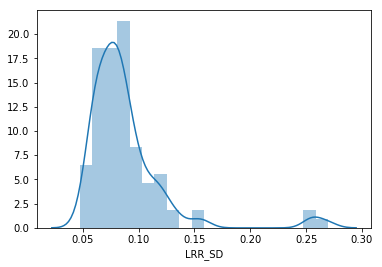

In [20]:
df = pd.read_table('/data/sudregp/cnv/penncnv/results/all_simplex_adjusted.qcsum')
# we ran for all samples, but let's look at only stats for samples in our simplex study
keep_me = [i for i in range(df.shape[0]) if df.File[i].split('/')[-1] in samples]
df = df.iloc[keep_me]

sns.distplot(df.LRR_SD)

Even though all our samples seem to be within the normal thresholds, there are a few which deviate from the overall distribution:

In [61]:
df[df.LRR_SD > .2]

,File,LRR_mean,LRR_median,LRR_SD,BAF_mean,BAF_median,BAF_SD,BAF_drift,WF,NumCNV
6,InfiniumExome/CLIA_400149,-0.0409,0.0,0.2695,0.5060,0.5,0.0499,0.000311,0.0519,472
49,InfiniumExome/CLIA_400126,-0.0518,0.0,0.2546,0.5042,0.5,0.0547,0.000449,0.0330,55
83,InfiniumExome/CLIA_400203,-0.0471,0.0,0.2566,0.5010,0.5,0.0475,0.000371,0.0683,310


Interestingly, they're not the CCGO samples, which I'd have guessed because they come from a different array. For peace of mind, let's remove those samples. Who are they in the families?

In [23]:
[trio for trio in trios for m in ['father', 'mother', 'child'] if trio[m] == 'CLIA_400149']

[{'child': 'CLIA_400149',
  'famid': '10173',
  'father': 'CLIA_400150',
  'mother': 'CLIA_400147'}]

In [24]:
[trio for trio in trios for m in ['father', 'mother', 'child'] if trio[m] == 'CLIA_400126']

[{'child': 'CLIA_400126',
  'famid': '10042',
  'father': 'CLIA_400146',
  'mother': 'CLIA_400145'}]

In [25]:
[trio for trio in trios for m in ['father', 'mother', 'child'] if trio[m] == 'CLIA_400203']

[{'child': 'CLIA_400203',
  'famid': '1976',
  'father': 'CLIA_400206',
  'mother': 'CLIA_400202'}]

OK, they're all children...

In [26]:
for s in ['CLIA_400149', 'CLIA_400126', 'CLIA_400203']:
    if s in affected:
        print s, 'is affected'

CLIA_400149 is affected
CLIA_400126 is affected


Well, we lose two families here. Let's continue.

# Raw CNV quality

```
in this we excluded outlying samples which had either [..] or showed an excessive number of raw CNV calls over 10 kb or an excessive number of CNVs over 100 kb (>30), and those with abnormally large CNV aberrations (>10 Mb) indicative of cell line artifacts.
```

Let's count how many CNVs fall into those 2 categories, out of our good samples:

In [65]:
bad_lrrsd = df[df.LRR_SD > .2].File

fid = open('/home/sudregp/data/cnv/penncnv/results/all_simplex_adjusted.rawcnv',
           'r')
rows = []
for line in fid:
    pars = line.split(' ')
    pars = [p for p in pars if p is not '']
    sample = pars[4]
    if sample.split('/')[-1] in samples and sample not in list(bad_lrrsd):
        nsnp = int(pars[1].split('=')[-1])
        length = int(pars[2].split('=')[-1].replace(',', ''))
        rows.append([sample, nsnp, length])
cnv_df = pd.DataFrame(rows, columns=['file', 'nsnp', 'length'])

cnv_df.head()

,file,nsnp,length
0,InfiniumExome/CLIA_400121,3,98
1,InfiniumExome/CLIA_400121,3,1883
2,InfiniumExome/CLIA_400121,22,1164
3,InfiniumExome/CLIA_400125,6,77791
4,InfiniumExome/CLIA_400125,12,74183


In [80]:
cnv10k = cnv_df[cnv_df.length>10*10**3].file.value_counts(sort=True)
cnv100k = cnv_df[cnv_df.length>100*10**3].file.value_counts(sort=True)
cnv10m = cnv_df[cnv_df.length>10*10**6].file.value_counts(sort=True)

In [82]:
print cnv10m.shape
print cnv10k.shape
print cnv100k.shape

(0,)
(40,)
(14,)


OK, so no one with obvious cell artifacts. Let's see what the issue is with 100K CNVs:

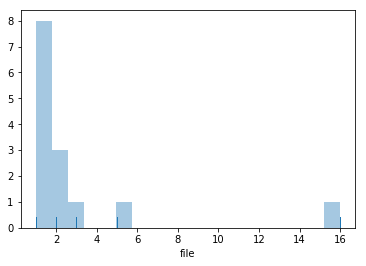

In [83]:
sns.distplot(cnv100k, kde=False, rug=True)

No one is approach the 30 safety mark they had in the study, but we do have one or two that are a bit too high compared to the rest. How do they look like in the 10K distribution?

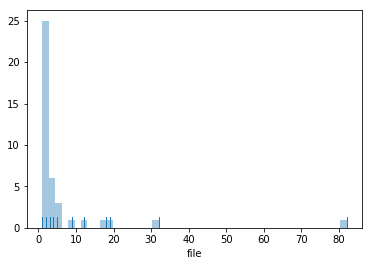

In [84]:
sns.distplot(cnv10k, kde=False, rug=True)

Are they the same?

In [88]:
print cnv10k.head()
print cnv100k.head()

InfiniumExome/CLIA_400172    82
InfiniumExome/CLIA_400181    32
InfiniumExome/CLIA_400125    19
InfiniumExome/CLIA_400163    18
InfiniumExome/CLIA_400145    12
Name: file, dtype: int64
InfiniumExome/CLIA_400172    16
InfiniumExome/CLIA_400181     5
InfiniumExome/CLIA_400125     3
InfiniumExome/CLIA_400163     2
InfiniumExome/CLIA_400175     2
Name: file, dtype: int64


Let's see who they are:

In [89]:
[trio for trio in trios for m in ['father', 'mother', 'child'] if trio[m] == 'CLIA_400172']

[{'child': 'CLIA_400172',
  'famid': '10182',
  'father': 'CLIA_400188',
  'mother': 'CLIA_400171'}]

In [90]:
[trio for trio in trios for m in ['father', 'mother', 'child'] if trio[m] == 'CLIA_400181']

[{'child': 'CLIA_400181',
  'famid': '10197',
  'father': 'CLIA_400185',
  'mother': 'CLIA_400184'}]

I'll likely drop those two. But let's also check the numbers of SNPs, just for kicks:

In [92]:
cnv_df[cnv_df.nsnp>15].file.value_counts(sort=True).head()

InfiniumExome/CLIA_400172    23
InfiniumExome/CLIA_400181    17
InfiniumExome/CLIA_400163     7
InfiniumExome/CLIA_400125     5
InfiniumExome/CLIA_400145     5
Name: file, dtype: int64

But I don't want to exclude CNVs for now, just samples. These CNVs might change after joint calling, and we can always drop them later if we want. Also, the SNP threshold is array dependent, and I don't know if their threshold would also apply to our dataset.

In [104]:
a = list(cnv100k[cnv100k > 3].index)
bad_files = list(bad_lrrsd) + a
print bad_files

['InfiniumExome/CLIA_400149', 'InfiniumExome/CLIA_400126', 'InfiniumExome/CLIA_400203', 'InfiniumExome/CLIA_400172', 'InfiniumExome/CLIA_400181']


# Joint call CNVs

Now we can look at the joint called CNVs for only the good samples, and see if we need to exclude any other samples based on their number of CNVs. Luckily all the samples we're removing are kids, so we might still keep the other trios, and it also helps as we named the joint results based on the child's ID:

In [116]:
df = pd.read_table('/data/sudregp/cnv/penncnv/results/all_simplex_adjusted.qcsum')
# we ran for all samples, but let's look at only stats for samples in our simplex study
keep_me = [i for i in range(df.shape[0]) if df.File[i].split('/')[-1] in samples]
df = df.iloc[keep_me]

# now, for each trio I get the name of the kid and then the parents, and 
# update the NumCNV count in the dataframe
members = ['father', 'mother', 'child']
for trio in trios:
    fname = '/data/sudregp/cnv/penncnv/results/%s_adjusted.jointcnv' % trio['child']
    fid = open(fname, 'r')
    counts = {}
    for m in members:
        counts[m] = 0
    for line in fid:
        for m in members:
            if line.find(trio[m]) > 0:
                counts[m] += 1
    for m in members:
        frow = [f for f in df.File if f.split('/')[-1] == trio[m]][0]
        df.loc[df.File == frow, 'NumCNV'] = counts[m]

# and remove the bad samples from above
keep_me = [i for i in df.index if df.File[i] not in bad_files]
df = df.loc[keep_me]
df.shape
        

(92, 10)

Now we can go ahead and replot the QC metrics:

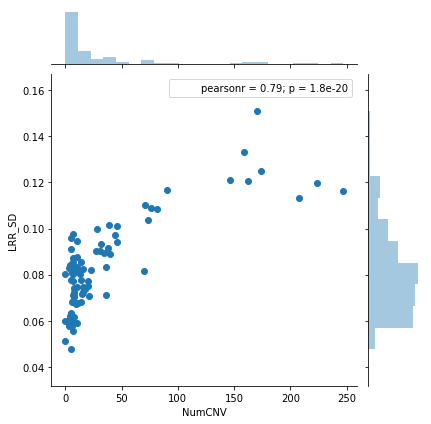

In [117]:
sns.jointplot(x='NumCNV', y='LRR_SD', data=df)

We still have a few samples with quite high numbers of CNVs. We could exclude them based on numCNV, but let's take a closer look. Maybe they're tiny CNVs, that we can get rid of by limiting their length in our analysis? If that's the case, they might also get overlapped when we merge nearby CNVs?

In [118]:
df[df.NumCNV > 200]

,File,LRR_mean,LRR_median,LRR_SD,BAF_mean,BAF_median,BAF_SD,BAF_drift,WF,NumCNV
9,InfiniumExome/CLIA_400173,-0.0098,0.0,0.1131,0.5015,0.5,0.0302,0.000000,0.0271,208
109,InfiniumExome/CLIA_400175,-0.0163,0.0,0.1161,0.4994,0.5,0.0302,0.000101,0.0183,247
120,InfiniumExome/CLIA_400145,-0.0052,0.0,0.1197,0.5024,0.5,0.0309,0.000000,0.0252,224


In [119]:
[trio for trio in trios for m in ['father', 'mother', 'child'] if trio[m] == 'CLIA_400175']

[{'child': 'CLIA_400175',
  'famid': '1892',
  'father': 'CLIA_400174',
  'mother': 'CLIA_400173'}]

In [124]:
print np.sum(cnv_df[cnv_df.file == 'InfiniumExome/CLIA_400175'].nsnp > 15)
print np.sum(cnv_df[cnv_df.file == 'InfiniumExome/CLIA_400175'].length > 100)

3
29


Yeah, they might go away... let's do these restrictions later then. We do need to have an idea of where to put those breaks, other than what's suggested in the papers:

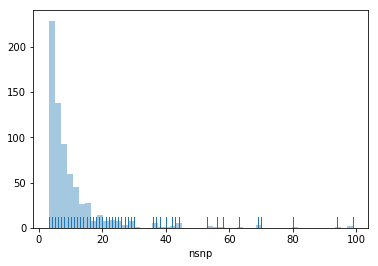

In [131]:
sns.distplot(cnv_df.nsnp, kde=False, rug=True)

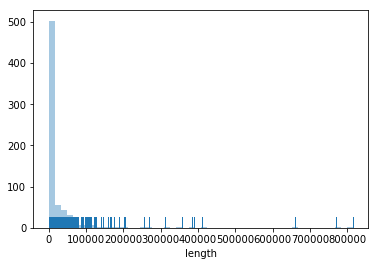

In [132]:
sns.distplot(cnv_df.length, kde=False, rug=True)

In [133]:
np.max(cnv_df.length)

814999

# Analysis

The approach here will be to analyze the data as is, then use some of those restrictions on CNV length and number of SNPs, and then do the same after merging CNVs, and finally after intersecting with the gene sets.

In [127]:
fid = open('/data/sudregp/cnv/penncnv/good_kids_joint_qc20171215.txt', 'w')
for f in df.File:
    sample = f.split('/')[-1]
    # control and affected only include kids!
    if sample in controls + affected:
        fid.write(sample + '\n')
fid.close()

In [128]:
%%bash
cd /data/sudregp/cnv/penncnv/results

echo "kid,denovo,inherited" > summary_called_qc20171215.csv;
while read sample; do
    triocnv=${sample}'_adjusted.jointcnv'
    rm denovo.txt inherited.txt 2>/dev/null
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    for snp in `grep offspring ${triocnv} | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_called_qc20171215.csv;
   rm *_snps;
done < ../good_kids_joint_qc20171215.txt

In [129]:
def plot_cnvs(fname, t_str):
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_csv(fname)
    df['total'] = df.denovo + df.inherited

    fig = tools.make_subplots(rows=3, cols=1, subplot_titles=('De Novo CNVs',
                                                              'Inherited CNVs',
                                                              'All CNVs'))

    for c, cnv in enumerate(['denovo', 'inherited', 'total']):
        x_red, x_green, red, green, xticks = [], [], [], [], []
        red_text, green_text = [], []

        # loop through families
        f = 0
        for fam in famids:
            fam_kids = [t['child'] for t in trios if t['famid'] == fam]
            found = False
            for kid in fam_kids:
                if kid in list(df.kid):
                    found = True
                    if kid in affected:
                        red.append(int(df[df.kid == kid][cnv]))
                        x_red.append(f)
                        red_text.append(kid)
                    else:
                        green.append(int(df[df.kid == kid][cnv]))
                        x_green.append(f)
                        green_text.append(kid)
            # only increase counter if we added a kid
            if found:
                xticks.append(fam)
                f += 1


        trace0 = go.Scatter(
            x = x_red,
            y = red,
            mode = 'markers',
            name = 'affected',
            marker = dict(size = 10, color = 'red'),
            text = red_text,
            hoverinfo='text+y',
            showlegend = False
        )
        trace1 = go.Scatter(
            x = x_green,
            y = green,
            mode = 'markers',
            name = 'unaffected',
            marker = dict(size = 10, color = 'green'),
            hovertext = green_text,
            hoverinfo='text+y',
            showlegend = False
        )
        fig.append_trace(trace0, c + 1, 1)
        fig.append_trace(trace1, c + 1, 1)

    fig['layout'].update(height=900, width=800, title=t_str,
                         xaxis1=dict(tickvals=range(len(xticks)),
                                    ticktext=xticks,
                                    zeroline = False),
                         xaxis2=dict(tickvals=range(len(xticks)),
                                    ticktext=xticks,
                                    zeroline = False),
                         xaxis3=dict(tickvals=range(len(xticks)),
                                    ticktext=xticks,
                                    zeroline = False),
                         hovermode='closest')
    fig['data'][0]['showlegend'] = True
    fig['data'][1]['showlegend'] = True
    iplot(fig)

In [4]:
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_called_qc20171215.csv',
          'All called (qc20171215)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [155]:
%%bash
cd /data/sudregp/cnv/penncnv/results

for x in 5 10 15; do
    echo "kid,denovo,inherited" > summary_called_nsnpBT${x}_qc20171215.csv;
    while read sample; do
        triocnv=${sample}'_adjusted.jointcnv'
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        # splits the second item on =, remove commas, and applies condition
        cat mom_snps dad_snps | awk -v x=$x '{split($2,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}' > parent_snps;
        for snp in `grep offspring ${triocnv} | awk -v x=$x '{split($2,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}'`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_called_nsnpBT${x}_qc20171215.csv;
       rm *_snps;
    done < ../good_kids_joint_qc20171215.txt;
done

In [5]:
for i in [5, 10, 15]:
    plot_cnvs('/data/sudregp/cnv/penncnv/results/' + 
              'summary_called_nsnpBT%d_qc20171215.csv' % i,
              'All called (numSNP > %d, qc20171215)' % i)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



Now let's try to clip on length of the CNV:

In [159]:
%%bash
cd /data/sudregp/cnv/penncnv/results

for x in 50000 100000 500000; do
    echo "kid,denovo,inherited" > summary_called_cnvlenBT${x}_qc20171215.csv;
    while read sample; do
        triocnv=${sample}'_adjusted.jointcnv'
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        # splits the second item on =, removes commas, and applies condition
        cat mom_snps dad_snps | awk -v x=$x '{split($3,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}' > parent_snps;
        for snp in `grep offspring ${triocnv} | awk -v x=$x '{split($3,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}'`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_called_cnvlenBT${x}_qc20171215.csv;
       rm *_snps;
    done < ../good_kids_joint_qc20171215.txt;
done

In [6]:
for i in [50000, 100000, 500000]:
    plot_cnvs('/data/sudregp/cnv/penncnv/results/' + 
              'summary_called_cnvlenBT%d_qc20171215.csv' % i,
              'All called (CNV length > %d bp, qc20171215)' % i)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



## Merged CNVs

Couldn't do it through PennCNV... clean_cnv script kept crashing. Will need to do it through PLINK later.

## Gene set intersections

In [162]:
%%bash

module load penncnv
cd /data/sudregp/cnv/penncnv/results

while read sample; do
    cnv=${sample}'_adjusted.jointcnv'
    gene=/fdb/annovar/current/hg19/hg19_refGene.txt
    link=/fdb/annovar/current/hg19/hg19_refLink.txt

    # there are some differences in the files...
    scan_region.pl ${cnv} $gene -refexon -reflink $link > ${cnv}_refexon_qc20171215
    scan_region.pl ${cnv} $gene -refgene -reflink $link > ${cnv}_refgene_qc20171215

    gene=/fdb/annovar/current/hg19/hg19_knownGene.txt
    link=/fdb/annovar/current/hg19/hg19_kgXref.txt
    scan_region.pl ${cnv} $gene -knowngene -kgxref $link > ${cnv}_knowngene_qc20171215
done < ../good_kids_joint_qc20171215.txt


In [163]:
%%bash
cd /data/sudregp/cnv/penncnv/results

for filter in refgene refexon knowngene; do
    echo "kid,denovo,inherited" > summary_${filter}_qc20171215.csv;
    while read sample; do
        triocnv=${sample}'_adjusted.jointcnv_'${filter}_qc20171215
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        cat mom_snps dad_snps | grep -v NOT_FOUND > parent_snps;
        for snp in `grep offspring ${triocnv} | grep -v NOT_FOUND | cut -d' ' -f 1`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_qc20171215.csv;
       rm *_snps;
    done < ../good_kids_joint_qc20171215.txt;
done

In [170]:
%%bash
cd /data/sudregp/cnv/penncnv/results

filter=brain

echo "kid,denovo,inherited" > summary_${filter}_qc20171215.csv;
while read sample; do
    triocnv=${sample}'_adjusted.jointcnv_knowngene_qc20171215'
    rm denovo.txt inherited.txt 2>/dev/null
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps | grep -f ../hg19_allenBrainGene_trimmed.txt > parent_snps;
    for snp in `grep offspring ${triocnv} | grep -f ../hg19_allenBrainGene_trimmed.txt | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_qc20171215.csv;
   rm *_snps;
done < ../good_kids_joint_qc20171215.txt;

In [7]:
for i in ['refgene', 'refexon', 'knowngene', 'brain']:
    plot_cnvs('/data/sudregp/cnv/penncnv/results/' + 
              'summary_%s_qc20171215.csv' % i,
              'In %s DB (qc20171215)' % i)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [173]:
%%bash
cd /data/sudregp/cnv/penncnv/results

for filter in refgene refexon knowngene; do
    for x in 5 10 15; do
        echo "kid,denovo,inherited" > summary_${filter}_numsnpBT${x}_qc20171215.csv;
        while read sample; do
            triocnv=${sample}'_adjusted.jointcnv_'${filter}_qc20171215
            rm denovo.txt inherited.txt 2>/dev/null
            grep mother ${triocnv} > mom_snps;
            grep father ${triocnv} > dad_snps;
            cat mom_snps dad_snps | grep -v NOT_FOUND | awk -v x=$x '{split($2,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}' > parent_snps;
            for snp in `grep offspring ${triocnv} | grep -v NOT_FOUND | awk -v x=$x '{split($2,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}'`; do
                if ! grep -q $snp parent_snps; then
                    echo "$snp" >> denovo.txt
                else
                    echo "$snp" >> inherited.txt
                fi;
           done
           echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_numsnpBT${x}_qc20171215.csv;
           rm *_snps;
        done < ../good_kids_joint_qc20171215.txt;
    done;
done

filter=brain
for x in 5 10 15; do
    echo "kid,denovo,inherited" > summary_${filter}_numsnpBT${x}_qc20171215.csv;
    while read sample; do
        triocnv=${sample}'_adjusted.jointcnv_knowngene_qc20171215'
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        cat mom_snps dad_snps | grep -f ../hg19_allenBrainGene_trimmed.txt | awk -v x=$x '{split($2,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}' > parent_snps;
        for snp in `grep offspring ${triocnv} | grep -f ../hg19_allenBrainGene_trimmed.txt | awk -v x=$x '{split($2,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}'`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_numsnpBT${x}_qc20171215.csv;
       rm *_snps;
    done < ../good_kids_joint_qc20171215.txt;
done;

In [8]:
for i in ['refgene', 'refexon', 'knowngene', 'brain']:
    for x in [5, 10, 15]:
        plot_cnvs('/data/sudregp/cnv/penncnv/results/' + 
                  'summary_%s_numsnpBT%d_qc20171215.csv' % (i, x),
                  'In %s DB (NumSNP > %d, qc20171215)' % (i, x))

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [176]:
%%bash
cd /data/sudregp/cnv/penncnv/results

for filter in refgene refexon knowngene; do
    for x in 50000 100000 500000; do
        echo "kid,denovo,inherited" > summary_${filter}_cnvlenBT${x}_qc20171215.csv;
        while read sample; do
            triocnv=${sample}'_adjusted.jointcnv_'${filter}_qc20171215
            rm denovo.txt inherited.txt 2>/dev/null
            grep mother ${triocnv} > mom_snps;
            grep father ${triocnv} > dad_snps;
            cat mom_snps dad_snps | grep -v NOT_FOUND | awk -v x=$x '{split($3,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}' > parent_snps;
            for snp in `grep offspring ${triocnv} | grep -v NOT_FOUND | awk -v x=$x '{split($3,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}'`; do
            if ! grep -q $snp parent_snps; then
                    echo "$snp" >> denovo.txt
                else
                    echo "$snp" >> inherited.txt
                fi;
           done
           echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_cnvlenBT${x}_qc20171215.csv;
           rm *_snps;
        done < ../good_kids_joint_qc20171215.txt;
    done;
done

filter=brain
for x in 50000 100000 500000; do
    echo "kid,denovo,inherited" > summary_${filter}_cnvlenBT${x}_qc20171215.csv;
    while read sample; do
        triocnv=${sample}'_adjusted.jointcnv_knowngene_qc20171215'
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        cat mom_snps dad_snps | grep -f ../hg19_allenBrainGene_trimmed.txt | awk -v x=$x '{split($3,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}' > parent_snps;
        for snp in `grep offspring ${triocnv} | grep -f ../hg19_allenBrainGene_trimmed.txt | awk -v x=$x '{split($3,arr,"="); sub(/,/,"",arr[2]); if (arr[2] > x) print $1}'`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_cnvlenBT${x}_qc20171215.csv;
       rm *_snps;
    done < ../good_kids_joint_qc20171215.txt;
done;

In [9]:
for i in ['refgene', 'refexon', 'knowngene', 'brain']:
    for x in [50000, 100000, 500000]:
        plot_cnvs('/data/sudregp/cnv/penncnv/results/' + 
                  'summary_%s_cnvlenBT%d_qc20171215.csv' % (i, x),
                  'In %s DB (CNV length > %d, qc20171215)' % (i, x))

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



OK, so there are enough this to look into here. Next step is to dig a little bit further into each of these results to see if they make sense.

# TODO

* how about a gene-level burden test, where we count genes with a CNV, rather than cnvs?
* separate into deletions and duplications!
* try furter qc. for example, from Thapar 2012: 

```
First, PLINK {Purcell, 2007 1026 /id} was used to identify potential errors in the CNV calls by excluding CNVs that had more than 50% of their length spanning an interSNP-gap of at least 100 kb. Then, to account for the possibility that longer CNVs were mistakenly split by the Hidden Markov Model (HMM) into multiple shorter CNVs, we merged all adjacent CNVs that occurred in a single individual, where the total length of all gaps was less than 50% of the entire length of the newly combined CNV.
In this study, we focused only on rare CNVs, which were defined by excluding any that had more than 50% of their length spanning any of the following three tracks; a) CNVs occurring more than 28 times (i.e. with >1% frequency) in our entire sample, b) known segmental duplications present in the human genome build 18 (hg18), c) known common CNVs defined by the Genome Structural Variation Consortium that are available for download at http://projects.tcag.ca/variation/ng42m_cnv.php. This procedure generated a list of 1562 rare CNVs larger than 100 kb. These CNVs were taken forward for association analysis which, in accordance with previous findings {International Schizophrenia Consortium, 2008 1436 /id}, we performed after stratifying by CNV size (>100 kb, >500 kb). We considered PennCNV copy number calls of 0 and 1 as deletions and 3, 4 or 5 as duplications.
```

* Try using quality score from https://www.ncbi.nlm.nih.gov/pubmed/27402902
* Try removing calls in immunoglobin, telomere and centromere regions (see PennCNV annotation page) 
* try merging adjacent CNV calls? (PennCNV can do it)
* how about transforming XHMM calls to Penncnv format to handle everything with similar scripts? Or the other approach is to create plink files for denovo and inherited SNPs, and do all the filtering in plink
* Worth calculating p-values? For that one trio it was always 0!
* Look into sex chromosomes? Something to the idea that adhd is more present in boys...
* Play with the HMM parameters
* compile a PFB file for this specific population?
* Include parent burden in the analysis
* Match with file of ranked simplex by Wendy (maybe blindly)?
* Do all of the above with XHMM and array data. Maybe start with array because it'll be simpler?